In [17]:
import sys
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
np.set_printoptions(precision=3, suppress=True)

In [18]:
def build_and_compile_model(norm):
    model = tf.keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10000])
    plt.xlabel('Epoch')
    plt.ylabel('Error [AVG]')
    plt.legend()
    plt.grid(True)

In [19]:
raw_dataset = pd.read_csv("data/train/end_data.csv")
raw_dataset.drop(columns=['geo_h3_10', 'Автозапчасти для иномарок', 'Авторемонт и техобслуживание (СТО)', 'Пункты выдачи интернет-заказов', 'Шиномонтаж', 'Страхование', 'Постаматы'], inplace=True)
dataset = raw_dataset.loc[:, ~raw_dataset.columns.str.contains('^Unnamed')]
dataset.fillna(0, inplace=True)
dataset.tail()

C:\Users\Sanya\AppData\Local\Temp\ipykernel_15884\1333313648.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.fillna(0, inplace=True)


,avg,population,Алкогольные напитки,Аптеки,Банки,Быстрое питание,Доставка готовых блюд,Женская одежда,Кафе,Косметика / Парфюмерия,Ногтевые студии,Овощи / Фрукты,Парикмахерские,Платёжные терминалы,Продуктовые магазины,Рестораны,Супермаркеты,Цветы,mall
208,1164.316667,1193.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
209,7628.333333,0.0,1.0,0.0,0.0,5.0,3.0,3.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0
210,10523.666667,0.0,0.0,2.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,2.0,0.0,1.0
211,2535.833333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
212,11759.750000,0.0,0.0,0.0,1.0,6.0,0.0,19.0,0.0,4.0,0.0,0.0,4.0,4.0,0.0,4.0,2.0,1.0,1.0


In [20]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [21]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('avg')
test_labels = test_features.pop('avg')

In [22]:
normalizer = tf.keras.layers.experimental.preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

In [23]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 18)                37        
_________________________________________________________________
dense_3 (Dense)              (None, 64)                1216      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 5,478
Trainable params: 5,441
Non-trainable params: 37
_________________________________________________________________


In [24]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=500)

CPU times: total: 1min 37s
Wall time: 14.9 s


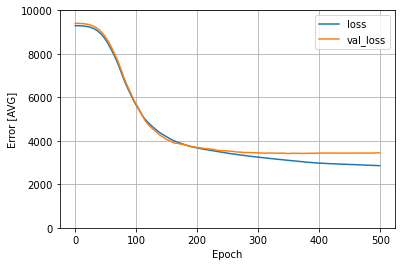

In [25]:
plot_loss(history)

In [26]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
495,2860.627441,3441.969482,495
496,2860.027588,3439.583496,496
497,2859.273438,3442.020508,497
498,2858.067627,3445.028076,498
499,2858.430420,3447.700195,499


In [27]:
dnn_model.evaluate(test_features, test_labels, verbose=0)

3561.861572265625

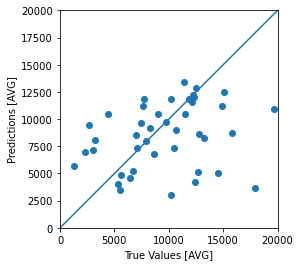

In [28]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [AVG]')
plt.ylabel('Predictions [AVG]')
lims = [0, 20000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)